# Estimating Treatment Effect Using Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import lifelines
import itertools

plt.rcParams["figure.figsize"] = (10, 7)

### Data Processing

In [2]:
data = pd.read_csv("assignments/C3_W1/levamisole_data.csv", index_col=0)

In [3]:
print(data.shape)
data.head()

(607, 14)


,sex,age,obstruct,perfor,adhere,nodes,node4,outcome,TRTMT,differ_2.0,differ_3.0,extent_2,extent_3,extent_4
1,1,43,0,0,0,5.0,1,1,True,1,0,0,1,0
2,1,63,0,0,0,1.0,0,0,True,1,0,0,1,0
3,0,71,0,0,1,7.0,1,1,False,1,0,1,0,0
4,0,66,1,0,0,6.0,1,1,True,1,0,0,1,0
5,1,69,0,0,0,22.0,1,1,False,1,0,0,1,0


- `sex` - `1` if Male, `0` otherwise
- `age` - age of pateint at start of the study
- `obstruct` - obstruction of colon by tumor
- `perfor` - perforation of colon
- `adhere` - adherence to nearby organs
- `nodes` - number of lumphnodes with detectable cancer
- `node4` - more than 4 positive lymph nodes
- `outcome` - `1` if died within 5 years, `0` otherwise
- `TRTMT` - teated with levamisole + fluoroucil
- `differ` - differentiation of tumor
- `extent` - extent of local spread

Finding treatment probability.

$$p_{treatment} = \frac{n_{treatment}}{n}$$

- $n_{treatment}$ is the number of patients where `TRTMT = True`
- $n$ is the total number of patients.

In [4]:
def proportion_treated(df):
    proportion = len(df[df["TRTMT"] == 1]) / len(df)
    
    return proportion

In [10]:
p = proportion_treated(data)
print(f"{p} ~ {int(p * 100)}%")

0.49093904448105435 ~ 49%


Empirical 5-year death probability for the treated arm versus the control arm.

The probability of dying for patients who received the treatment is:

$$p_{\text{treatment, death}} = \frac{n_{\text{treatment,death}}}{n_{\text{treatment}}}$$

- $n_{\text{treatment,death}}$ is the number of patients who received the treatment and died.
- $n_{\text{treatment}}$ is the number of patients who received treatment.

The probability of dying for patients in the control group (who did not received treatment) is:

$$p_{\text{control, death}} = \frac{n_{\text{control,death}}}{n_{\text{control}}}$$
- $n_{\text{control,death}}$ is the number of patients in the control group (did not receive the treatment) who died.
- $n_{\text{control}}$ is the number of patients in the control group (did not receive treatment).

In [12]:
def event_rate(df):
    treated_prob = 0.
    control_prob = 0.
    
    treated_prob = len(df[(df["TRTMT"] == 1) & (df["outcome"] == 1)]) / len(df[df["TRTMT"] == 1])
    control_prob = len(df[(df["TRTMT"] == 0) & (df["outcome"] == 1)]) / len(df[df["TRTMT"] == 0])
    
    return treated_prob, control_prob

In [13]:
treated_prob, control_prob = event_rate(data)

print(f"Death rate for treated patients: {treated_prob:.4f} ~ {int(treated_prob*100)}%")
print(f"Death rate for untreated patients: {control_prob:.4f} ~ {int(control_prob*100)}%")

Death rate for treated patients: 0.3725 ~ 37%
Death rate for untreated patients: 0.4822 ~ 48%


On average it seemed like treatment had a positive effect.

#### Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

data = data.dropna(axis=0)
y = data.outcome
X = data.drop('outcome', axis=1)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.25)

In [15]:
print(X_dev.shape)
print(X_test.shape)

(455, 13)
(152, 13)


## Modeling Treatment Effect

#### Constant Treatment Effect
First we will model the treatment effect using a standard logic regression. If $x^{(i)}$ is the input vector, then this models the probability of death within 5 years as 
$$\sigma(\theta^T x^{(i)}) = \frac{1}{1 + exp(-\theta^T x^{(i)})},$$

where $ \theta^T x^{(i)} = \sum_{j} \theta_j x^{(i)}_j$ is an inner product. 

For example, if we have three features, $TRTMT$, $AGE$, and  $SEX$, then our probability of death would be written as: 

$$\sigma(\theta^T x^{(i)}) = \frac{1}{1 + exp(-\theta_{TRTMT} x^{(i)}_{TRTMT} - \theta_{AGE}x_{AGE}^{(i)} - \theta_{SEX}x^{(i)}_{SEX})}.$$


Another way to look at logistic regresion is as a linear model for the "logit" function, or "log odds": 

$$logit(p) = \log \left(\frac{p}{1-p} \right)= \theta^T x^{(i)}$$

- "Odds" is defined as the probability of an event divided by the probability of not having the event: $\frac{p}{1-p}$.  

- "Log odds", or "logit" function, is the natural log of the odds: $log \left(\frac{p}{1-p} \right)$

In this example, $x^{(i)}_{TRTMT}$ is the treatment variable. Therefore, $\theta_{TRTMT}$ tells you what the effect of treatment is. If $\theta_{TRTMT}$ is negative, then having treatment reduces the log-odds of death, which means death is less likely than if you did not have treatment. 

Note that this assumes a constant relative treatment effect, since the impact of treatment does not depend on any other covariates. 

Typically, a randomized control trial (RCT) will seek to establish a negative $\theta_{TRTMT}$ (because the treatment is intended to reduce risk of death), which corresponds to an odds ratio of less than 1.

An odds ratio of less than one implies the probability of death is less than the probability of surviving.

$$ \frac{p}{1-p} < 1 \rightarrow p < 1-p$$

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10_000).fit(X_dev, y_dev)

#### Calculating the Odds Ratio

You are interested in finding the odds for treatment relative to the odds for the baseline.

$$ OddsRatio = \frac{Odds_{treatment}}{Odds_{baseline}}$$

where
$$Odds_{treatment} = \frac{p_{treatment}}{1-p_{treatment}}$$

and 

$$Odds_{baseline} = \frac{p_{baseline}}{1-p_{baseline}}$$

#### Odds Ratio

The Odds ratio is:

$$ OddsRatio = \frac{Odds_{treatment}}{Odds_{baseline}}$$

Doing some substitution:

$$ OddsRatio = \frac{e^{\theta_{treatment} \times 1 + \theta_{age} \times x_{age}^{(i)} + \cdots}}{e^{0 + \theta_{age} \times x_{age}^{(i)} + \cdots}}$$

Notice that $e^{\theta_{age} \times x_{age}^{(i)} + \cdots}$ cancels on top and bottom, so that:

$$ OddsRatio = \frac{e^{\theta_{treatment} \times 1}}{e^{0}}$$

Since $e^{0} = 1$, This simplifies to:

$$ OddsRatio = e^{\theta_{treatment}}$$

In [19]:
def extract_treatment_effect(lr, data):
    theta_TRTMT = 0.
    TRTMT_OR = 0.
    coeffs = {data.columns[i]:lr.coef_[0][i] for i in range(len(data.columns))}
    
    theta_TRTMT = coeffs['TRTMT']
    TRTMT_OR = np.exp(theta_TRTMT)
    
    return theta_TRTMT, TRTMT_OR

In [20]:
theta_TRTMT, trtmt_OR = extract_treatment_effect(lr, X_dev)
print(f"Theta_TRTMT: {theta_TRTMT:.4f}")
print(f"Treatment Odds Ratio: {trtmt_OR:.4f}")

Theta_TRTMT: -0.5315
Treatment Odds Ratio: 0.5877


- The $\theta_{treatment} = -0.53$ is a negative value, meaning that it has the effect of reducing risk of death.
- In the code above, the $OddsRatio$ is stored in the variable `TRTMT_OR`.
- The $OddsRatio = 0.58$, which is less than 1.  

You can think of the $OddsRatio$ as a factor that is multiplied to the baseline odds $Odds_{baseline}$ in order to estimate the $Odds_{treatment}$.  You can think about the Odds Ratio as a rate, converting between baseline odds and treatment odds.

$$Odds_{treatment} = OddsRatio \times Odds_{baseline}$$

In this case:

$$Odds_{treatment} = 0.58 \times Odds_{baseline}$$

So you can interpret this to mean that the treatment reduces the odds of death by $(1 - OddsRatio) = 1 - 0.58 = 0.42$, or about 42%.

#### Absolute Risk Reduction (ARR)

A valuable quantity is the absolute risk reduction (ARR) of a treatment. If $p$ is the baseline probability of death, and $p_{treatment}$ is the probability of death if treated, then 
$$ARR = p_{baseline} - p_{treatment} $$

In the case of logistic regression, here is how ARR can be computed:  
Recall that the Odds Ratio is defined as:

$$OR = Odds_{treatment} / Odds_{baseline}$$

where the "odds" is the probability of the event over the probability of not having the event, or $p/(1-p)$. 

$$Odds_{trtmt} = \frac{p_{treatment}}{1- p_{treatment}}$$
and
$$Odds_{baseline} = \frac{p_{baseline}}{1- p_{baseline}}$$

In [21]:
def OR_to_ARR(p, OR):
    odds_baseline = p / (1 - p)
    
    odds_trtmt = OR * odds_baseline
    
    p_trtmt = odds_trtmt / (1 + odds_trtmt)
    
    ARR = p - p_trtmt
    
    return ARR

The logistic regression model assumes that treatment has a constant effect in terms of odds ratio and is independent of other covariates. 

However, this does not mean that absolute risk reduction is necessarily constant for any baseline risk $\hat{p}$. To illustrate this, we can plot absolute risk reduction as a function of baseline predicted risk $\hat{p}$. 

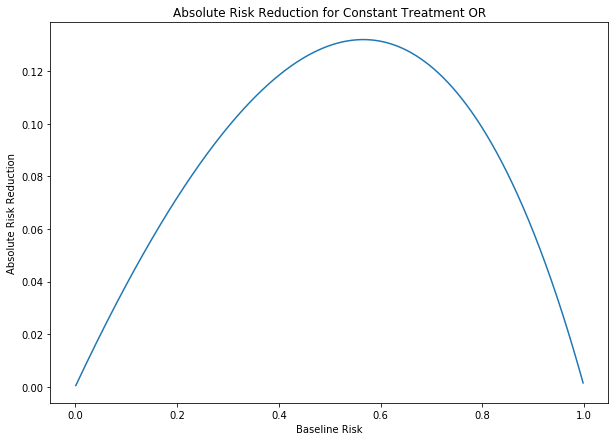

In [22]:
ps = np.arange(0.001, 0.999, 0.001)
diffs = [OR_to_ARR(p, trtmt_OR) for p in ps]
plt.plot(ps, diffs)
plt.title("Absolute Risk Reduction for Constant Treatment OR")
plt.xlabel('Baseline Risk')
plt.ylabel('Absolute Risk Reduction')
plt.show()

We can now plot how closely the empirical (actual) risk reduction matches the risk reduction that is predicted by the logistic regression model. 

This is complicated by the fact that for each patient, we only observe one outcome (treatment or no treatment). 
- We can't give a patient treatment, then go back in time and measure an alternative scenario where the same patient did not receive the treatment.
- Therefore, we will group patients into groups based on their baseline risk as predicted by the model, and then plot their empirical ARR within groups that have similar baseline risks.
- The empirical ARR is the death rate of the untreated patients in that group minus the death rate of the treated patients in that group.

$$ARR_{empirical} = p_{baseline} - p_{treatment}$$

In [30]:
def base_risks(X, lr_model):
    X = X.copy(deep=True)
    
    X["TRTMT"] = 0
    
    risks = lr_model.predict_proba(X)[:, 1]
    
    return risks

#### ARR by quantile

Since the effect of treatment varies depending on the baseline risk, it makes more sense to group patients who have similar baseline risks, and then look at the outcomes of those who receive treatment versus those who do not, to estimate the absolute risk reduction (ARR).

In [33]:
def lr_ARR_quantile(X, y, lr):
    X = X.copy(deep=True)
    
    df = X.copy(deep=True)
    
    baseline_risk = base_risks(df, lr)
    
    risk_groups = pd.cut(baseline_risk, 10)
    
    df.loc[: ,'baseline_risk'] = baseline_risk
    df.loc[: ,'risk_group'] = risk_groups
    df.loc[: ,'y'] = y

    df_baseline = df[df["TRTMT"] == False]
    df_treatment = df[df["TRTMT"] == True] 
    
    baseline_mean_by_risk_group = df_baseline.groupby("risk_group")['y'].mean()
    treatment_mean_by_risk_group = df_treatment.groupby("risk_group")['y'].mean()
    
    arr_by_risk_group = baseline_mean_by_risk_group - treatment_mean_by_risk_group
    
    arr_by_risk_group.index = df_treatment.groupby('risk_group')['baseline_risk'].mean()
    
    arr_by_risk_group.name = "ARR"
    
    return arr_by_risk_group

In [34]:
abs_risks = lr_ARR_quantile(X_dev, y_dev, lr)

print(abs_risks)

display(pd.DataFrame(abs_risks))

baseline_risk
0.213626    0.006410
0.292042    0.035714
0.369317    0.130435
0.443978    0.132143
0.519690    0.085714
0.590685    0.000000
0.699381   -0.034965
0.765163    0.290196
0.842173    0.218182
0.925664    0.123077
Name: ARR, dtype: float64


,ARR
baseline_risk,
0.213626,0.006410
0.292042,0.035714
0.369317,0.130435
0.443978,0.132143
0.519690,0.085714
0.590685,0.000000
0.699381,-0.034965
0.765163,0.290196
0.842173,0.218182


Plot the ARR grouped by baseline risk:

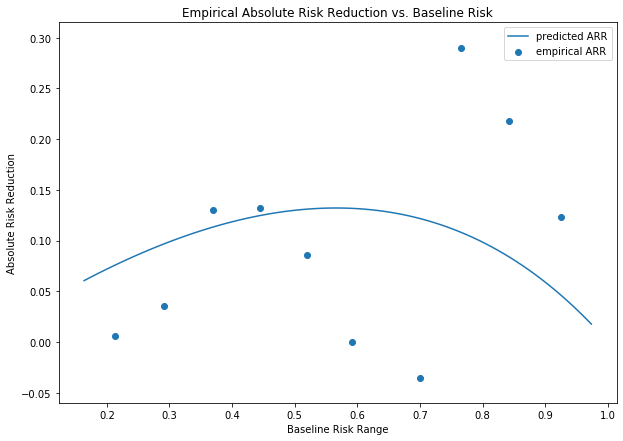

In [35]:
plt.scatter(abs_risks.index, abs_risks, label='empirical ARR')
plt.title("Empirical Absolute Risk Reduction vs. Baseline Risk")
plt.ylabel("Absolute Risk Reduction")
plt.xlabel("Baseline Risk Range")
ps = np.arange(abs_risks.index[0]-0.05, abs_risks.index[-1]+0.05, 0.01)
diffs = [OR_to_ARR(p, trtmt_OR) for p in ps]
plt.plot(ps, diffs, label='predicted ARR')
plt.legend(loc='upper right')
plt.show()

n the plot, the empirical absolute risk reduction is shown as circles, whereas the predicted risk reduction from the logistic regression model is given by the solid line.

If ARR depended only on baseline risk, then if we plotted actual (empirical) ARR grouped by baseline risk, then it would follow the model's predictions closely (the dots would be near the line in most cases).

However, you can see that the empirical absolute risk reduction (shown as circles) does not match the predicted risk reduction from the logistic regression model (given by the solid line).

This may indicate that ARR may depend on more than simply the baseline risk.

### C-statistic-for-benefit (C-for-benefit)

You'll now use a measure to evaluate the discriminative power of your models for predicting ARR. Ideally, you could use something like the regular Concordance index (also called C-statistic). Proceeding by analogy, you'd like to estimate something like:

$$P(A \text{ has higher predicted ARR than } B| A \text{ experienced a greater risk reduction than } B).$$

In [49]:
def c_for_benefit_score(pairs):
    obs_benefit_dict = {
        (0, 0): 0,
        (0, 1): -1,
        (1, 0): 1,
        (1, 1): 0
    }
    
    obs_benefit = [obs_benefit_dict[p[0][1], p[1][1]] for p in pairs]
    
    pred_benefit = [np.mean((p[0][0], p[1][0])) for p in pairs]
    
    concordant_count, permissible_count, risk_tie_count = 0, 0, 0
    
    for i in range(len(pairs)):
        for j in range(i+1, len(pairs)):
            if obs_benefit[i] != obs_benefit[j]:
                permissible_count += 1
                
                if (obs_benefit[i] < obs_benefit[j] and pred_benefit[i] < pred_benefit[j]) or (obs_benefit[i] > obs_benefit[j] and pred_benefit[i] > pred_benefit[j]):
                    concordant_count += 1
                    
                if (pred_benefit[i] == pred_benefit[j]):
                    risk_tie_count += 1
    cstat = (concordant_count + (0.5 * risk_tie_count)) / permissible_count

    return cstat

In [54]:
def c_statistic(pred_rr, y, w):
    tuples = list(zip(pred_rr, y, w))
    
    untreated = list(filter(lambda x: x[2] == 0, tuples))
    
    treated = list(filter(lambda x: x[2] == 1, tuples))
    
    if len(treated) < len(untreated):
        untreated = random.sample(untreated, len(treated))
        
    if len(untreated) < len(treated):
        treated = random.sample(treated, len(untreated))
            
    untreated = sorted(untreated, key=lambda x: x[0])

    treated = sorted(treated, key=lambda x: x[0])       

    pairs = list(zip(untreated, treated))

    cstat = c_for_benefit_score(pairs)

    return cstat

### Predicted risk reduction

In order to compute the c-statistic-for-benefit for any of your models, you need to compute predicted risk reduction from treatment (predicted risk reduction is the input `pred_rr` to the c-statistic function).

- The easiest way to do this in general is to create a version of the data where the treatment variable is False and a version where it is True.
- Then take the difference $\text{pred_RR} = p_{control} - p_{treatment}$

In [63]:
def treatment_control(X):
    X_treatment = X.copy(deep=True)
    X_control = X.copy(deep=True)
    X_treatment.loc[:, 'TRTMT'] = 1
    X_control.loc[:, 'TRTMT'] = 0
    return X_treatment, X_control

def risk_reduction(model, data_treatment, data_control):
    treatment_risk = model.predict_proba(data_treatment)[:, 1]
    control_risk = model.predict_proba(data_control)[:, 1]
    
    return treatment_risk - control_risk

In [64]:
X_test_treated, X_test_untreated = treatment_control(X_test)
rr_lr = risk_reduction(lr, X_test_treated, X_test_untreated)

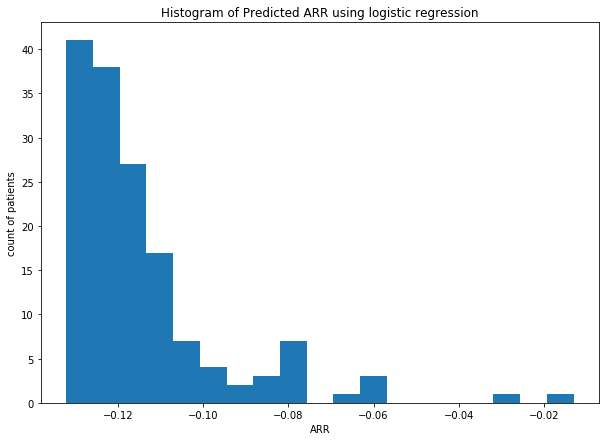

In [65]:
plt.hist(rr_lr, bins='auto')
plt.title("Histogram of Predicted ARR using logistic regression")
plt.ylabel("count of patients")
plt.xlabel("ARR")
plt.show()

In [66]:
tmp_cstat_test = c_statistic(rr_lr, y_test, X_test.TRTMT)
print(f"Logistic Regression evaluated by C-for-Benefit: {tmp_cstat_test:.4f}")

Logistic Regression evaluated by C-for-Benefit: 0.5528


#### Regular c-index

In [67]:
from lifelines.utils import concordance_index

tmp_regular_cindex = concordance_index(y_test, lr.predict_proba(X_test)[:, 1])
print(f"Logistic Regression evaluated by regular C-index: {tmp_regular_cindex:.4f}")

Logistic Regression evaluated by regular C-index: 0.6486


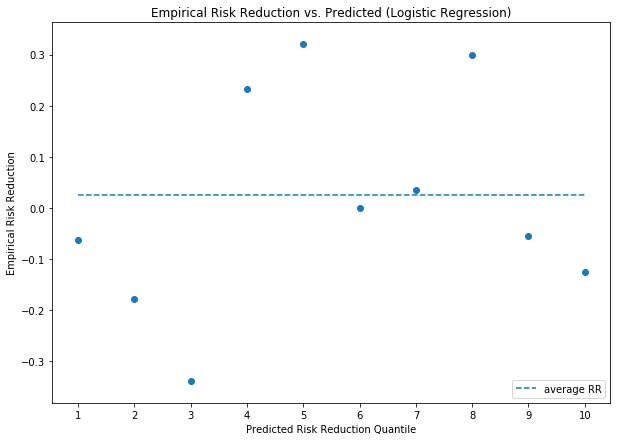

In [68]:
def quantile_benefit(X, y, arr_hat):
    df = X.copy(deep=True)
    df.loc[:, 'y'] = y
    df.loc[:, 'benefit'] = arr_hat
    benefit_groups = pd.qcut(arr_hat, 10)
    df.loc[:, 'benefit_groups'] = benefit_groups
    empirical_benefit = df.loc[df.TRTMT == 0, :].groupby('benefit_groups').y.mean() - df.loc[df.TRTMT == 1].groupby('benefit_groups').y.mean()
    avg_benefit = df.loc[df.TRTMT == 0, :].y.mean() - df.loc[df.TRTMT==1, :].y.mean()
    return empirical_benefit, avg_benefit

def plot_empirical_risk_reduction(emp_benefit, av_benefit, model):
    plt.scatter(range(len(emp_benefit)), emp_benefit)
    plt.xticks(range(len(emp_benefit)), range(1, len(emp_benefit) + 1))
    plt.title("Empirical Risk Reduction vs. Predicted ({})".format(model))
    plt.ylabel("Empirical Risk Reduction")
    plt.xlabel("Predicted Risk Reduction Quantile")
    plt.plot(range(10), [av_benefit]*10, linestyle='--', label='average RR')
    plt.legend(loc='lower right')
    plt.show()

emp_benefit, avg_benefit = quantile_benefit(X_test, y_test, rr_lr)
plot_empirical_risk_reduction(emp_benefit, avg_benefit, "Logistic Regression")

### Machine Learning Approaches

##### T-Learner

Now you will see how recent machine learning approaches compare to the more standard analysis. The approach we'll look at is called [T-learner](https://arxiv.org/pdf/1706.03461.pdf).
- "T" stands for "two". 
- The T-learner learns two different models, one for treatment risk, and another model for control risk.
- Then takes the difference of the two risk predictions to predict the risk reduction.


In [69]:
class TLearner():
    def __init__(self, treatment_estimator, control_estimator):
        self.treatment_estimator = treatment_estimator 
        self.control_estimator = control_estimator
        
    def predict(self, X):
        risk_control = self.control_estimator.predict_proba(X)[:, 1]
        risk_treatment = self.treatment_estimator.predict_proba(X)[:, 1]  
        
        pred_risk_reduction = risk_control - risk_treatment
        
        return pred_risk_reduction

##### Tuning the model with grid search

In order to tune your two models, you will use grid search to find the desired parameters.
- You will use a validation set to evaluate the model on different parameters, in order to avoid overfitting to the training set.

To test models on all combinations of hyperparameters, you can first list out all of the values in a list of lists.

In [ ]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparam, verbose=False):
    best_estimator = None
    best_hyperparam = {}
    best_score = 0.0
    
    hyper_param_l = list(hyperparam.values())
    combination_l_of_t = list(itertools.product(*hyper_param_l))
    combination_l_of_d = []
    
    for val_tuple in combination_l_of_t:
        param_d = {}
        
        for i, k in enumerate(hyperparam.keys()):
            param_d[k] = val_tuple[i]
        
        combination_l_of_d.append(param_d)